In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
from src.model import PlantDiseaseResNet
from src.data import get_loaders
from src.train import train


## Load Data + Init Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader = get_loaders("../data/PlantVillage", img_size=224, batch_size=32)

model = PlantDiseaseResNet(num_classes=15).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # higher LR is OK since only FC is training

train(model, train_loader, val_loader, criterion, optimizer, device, epochs=4)



Epoch 1/4


Train Loss: 0.8305, Acc: 0.7821 | Val Loss: 0.4096, Acc: 0.8898

Epoch 2/4


Train Loss: 0.3846, Acc: 0.8910 | Val Loss: 0.3040, Acc: 0.9138

Epoch 3/4


Train Loss: 0.3078, Acc: 0.9073 | Val Loss: 0.2671, Acc: 0.9225

Epoch 4/4


Train Loss: 0.2695, Acc: 0.9164 | Val Loss: 0.2373, Acc: 0.9276


## Save the Model

In [4]:
torch.save(model.state_dict(), "../outputs/resnet18_transfer.pth")


In [5]:
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(model.base_model.fc.weight.device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


## Confusion Matrix

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


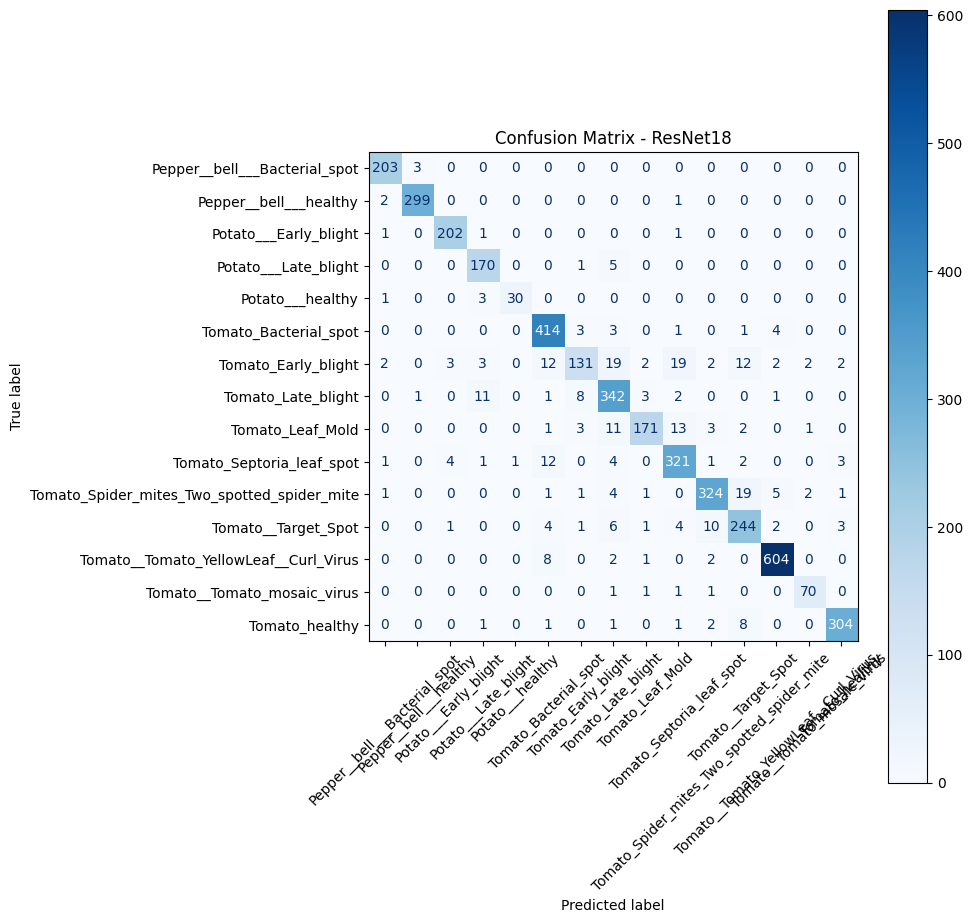

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.model import PlantDiseaseResNet
model = PlantDiseaseResNet(num_classes=15)
model.load_state_dict(torch.load("../outputs/resnet18_transfer.pth"))
model.eval()

# Load class names
dataset = val_loader.dataset
class_names = dataset.dataset.classes  # because val_loader uses Subset

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - ResNet18")
plt.tight_layout()
plt.savefig("../outputs/figures/confusion_matrix_resnet.png")
plt.show()


## ROC Curves (Multiclass)

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


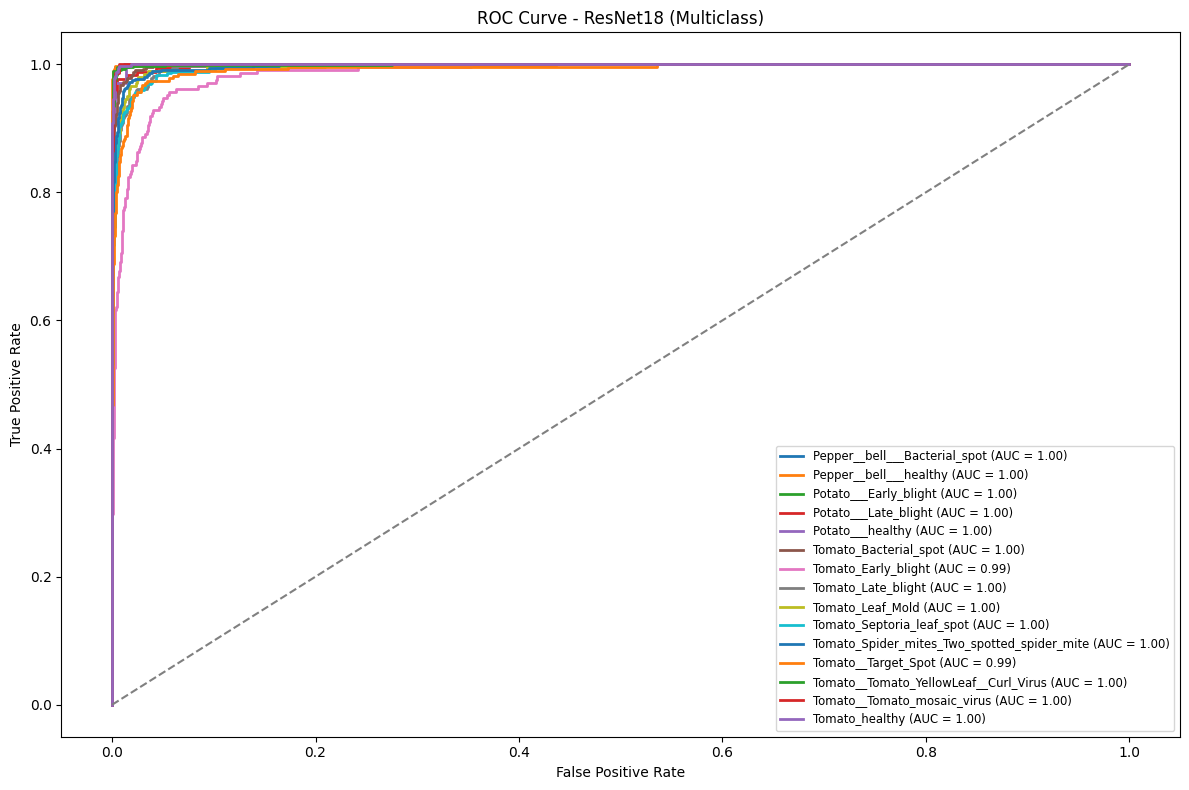

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from src.model import PlantDiseaseResNet

# Load model
model = PlantDiseaseResNet(num_classes=15)
model.load_state_dict(torch.load("../outputs/resnet18_transfer.pth"))
model.eval()

# Get class names
dataset = val_loader.dataset
class_names = dataset.dataset.classes  # because of Subset in DataLoader

# Get predictions
all_probs = []
all_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(model.base_model.fc.weight.device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Binarize labels
n_classes = 15
true_binarized = label_binarize(all_true, classes=np.arange(n_classes))

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ResNet18 (Multiclass)")
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.savefig("../outputs/figures/roc_curve_resnet.png")
plt.show()
